In [1]:
options(warn = -1)
suppressMessages(library(neotoma2))
suppressMessages(library(sf))
suppressMessages(library(geojsonsf))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(leaflet))
suppressWarnings(library(dplyr))

options(dplyr.summarise.inform = FALSE)

In [2]:
cz_dl <- readRDS('data/czDownload.RDS')
allSamp <- samples(cz_dl)

translation <- readr::read_csv("data/taxontable.csv")
allSamp <- allSamp %>%
  inner_join(translation, by = c("variablename" = "variablename")) %>% 
  select(!c("variablename", "sites", "samples")) %>% 
  group_by(siteid, sitename, replacement,
           sampleid, units, age,
           agetype, depth, datasetid,
           long, lat) %>%
  summarise(value = sum(value))

Rows: 1195 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): variablename, replacement
dbl (2): sites, samples

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Doing Basic Analysis

- We now have site information across the Czech Republic, with samples, and with taxon names. 

- Let's look at the distributions of taxa across time, simply their presence absence. 

- Pick the top 20 taxa (based on the number of times they appear in the records) and look at their distributions in time

In [3]:
taxabyage <- allSamp %>% 
  group_by(replacement, "age" = round(age, -2)) %>% 
  summarise(n = n())

In [4]:
samplesbyage <- allSamp %>% 
  group_by("age" = round(age, -2)) %>% 
  summarise(samples = length(unique(sampleid)))

taxabyage <- taxabyage %>%
  inner_join(samplesbyage, by = "age") %>% 
  mutate(proportion = n / samples)

toptaxa <- taxabyage %>%
  group_by(replacement) %>%
  summarise(n = n()) %>%
  arrange(desc(n)) %>%
  head(n = 10)

groupbyage <- taxabyage %>%
  filter(replacement %in% toptaxa$replacement)

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



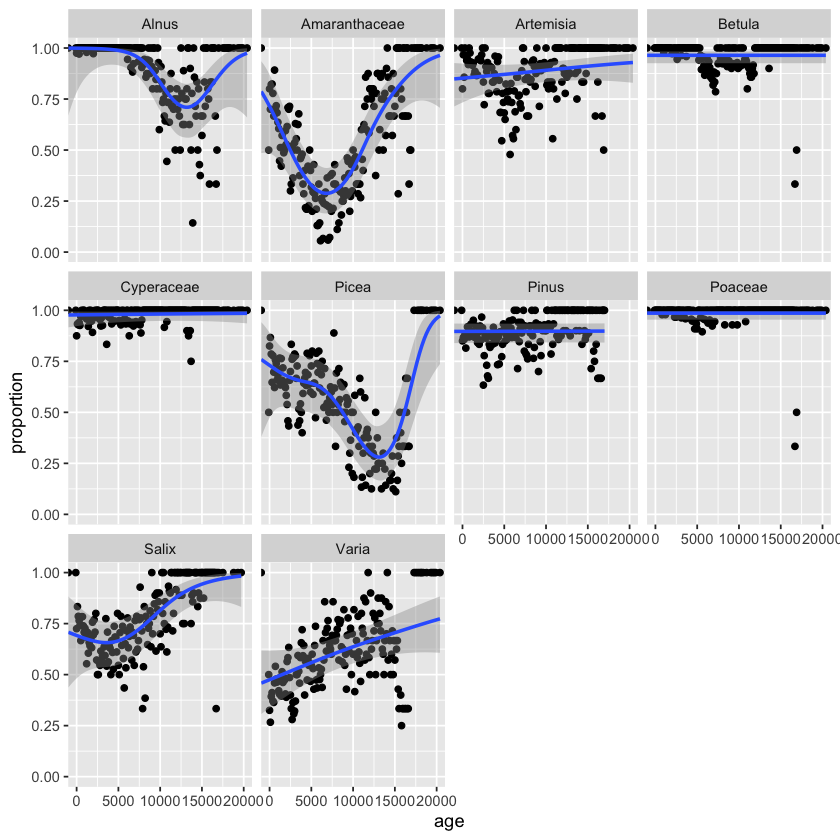

In [5]:
ggplot(groupbyage, aes(x = age, y = proportion)) +
  geom_point() +
  geom_smooth(method = 'gam', 
              method.args = list(family = 'binomial')) +
  facet_wrap(~replacement) +
  coord_cartesian(xlim = c(0, 20000), ylim = c(0, 1))

## Stratigraphic Plotting for One Site

In [6]:
# Get a particular site:
onesite <- samples(cz_dl[[1]]) %>% 
  inner_join(translation, by = c("variablename" = "variablename")) %>% 
  select(!c("variablename", "sites", "samples")) %>% 
  group_by(siteid, sitename, replacement,
           sampleid, units, age,
           agetype, depth, datasetid,
           long, lat) %>%
  summarise(value = sum(value))
DT::datatable(head(onesite, n = 20), rownames = FALSE)


HTML widgets cannot be represented in plain text (need html)

In [7]:
onesite <- onesite %>%
  filter(units == "NISP") %>%
  group_by(age) %>%
  mutate(pollencount = sum(value, na.rm = TRUE)) %>%
  group_by(replacement) %>% 
  mutate(prop = value / pollencount)

topcounts <- onesite %>%
  group_by(replacement) %>%
  summarise(n = n()) %>%
  arrange(desc(n)) %>%
  head(n = 10)

In [8]:
widetable <- onesite %>%
  filter(replacement %in% topcounts$replacement) %>%
  select(age, replacement, prop) %>% 
  mutate(prop = as.numeric(prop))

counts <- tidyr::pivot_wider(widetable,
                             id_cols = age,
                             names_from = replacement,
                             values_from = prop,
                             values_fill = 0)

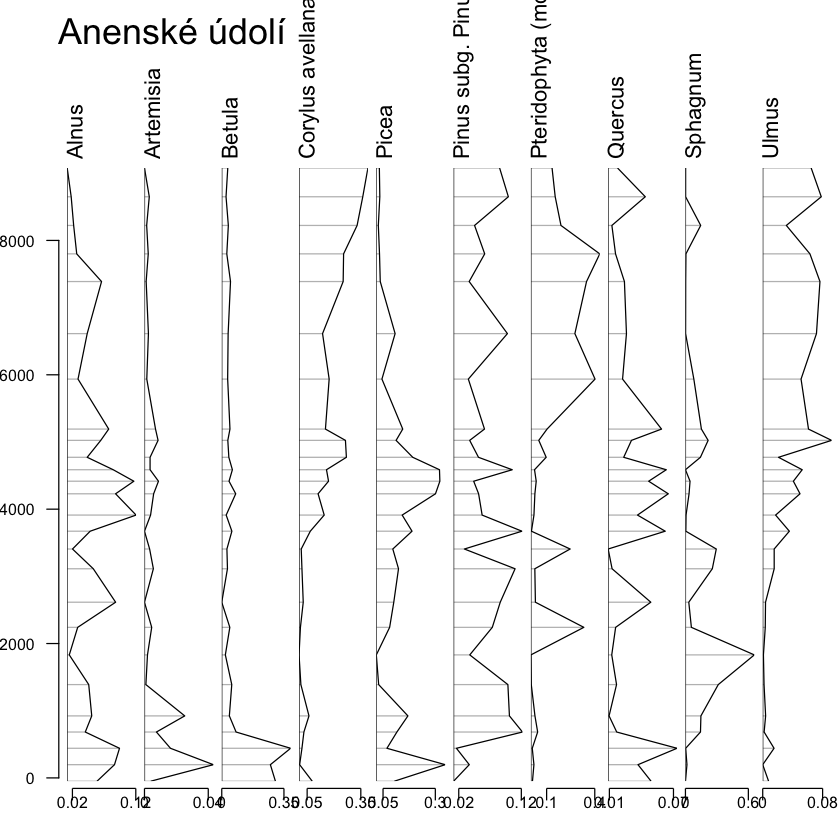

In [9]:
rioja::strat.plot(counts[,-1], yvar = counts$age,
                  title = cz_dl[[1]]$sitename)

## Using Spatial-based Data (July max temperature)

In [10]:
modern <- allSamp %>% filter(age < 50)

spatial <- sf::st_as_sf(modern, 
                        coords = c("long", "lat"),
                        crs = "+proj=longlat +datum=WGS84")

In [11]:
worldTmax <- raster::getData('worldclim', var = 'tmax', res = 10)
worldTmax

class      : RasterStack 
dimensions : 900, 2160, 1944000, 12  (nrow, ncol, ncell, nlayers)
resolution : 0.1666667, 0.1666667  (x, y)
extent     : -180, 180, -60, 90  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 
names      : tmax1, tmax2, tmax3, tmax4, tmax5, tmax6, tmax7, tmax8, tmax9, tmax10, tmax11, tmax12 


In [12]:
modern$tmax7 <- raster::extract(worldTmax, spatial)[,7]
head(modern)

siteid,sitename,replacement,sampleid,units,age,agetype,depth,datasetid,long,lat,value,tmax7
<int>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>
1399,Kameničky,Abies,342283,NISP,48,Calibrated radiocarbon years BP,0,1435,15.9706,49.72633,39,210
1399,Kameničky,Achillea,342283,NISP,48,Calibrated radiocarbon years BP,0,1435,15.9706,49.72633,2,210
1399,Kameničky,Alnus,342283,NISP,48,Calibrated radiocarbon years BP,0,1435,15.9706,49.72633,141,210
1399,Kameničky,Amaranthaceae,342283,NISP,48,Calibrated radiocarbon years BP,0,1435,15.9706,49.72633,2,210
1399,Kameničky,Apiaceae,342283,NISP,48,Calibrated radiocarbon years BP,0,1435,15.9706,49.72633,13,210
1399,Kameničky,Artemisia,342283,NISP,48,Calibrated radiocarbon years BP,0,1435,15.9706,49.72633,5,210


In [13]:
maxsamp <- modern %>% 
  group_by(siteid, sitename) %>% 
  dplyr::distinct(tmax7)
head(maxsamp)

siteid,sitename,tmax7
<int>,<chr>,<dbl>
1399,Kameničky,210
3052,Chraňbož,222
3090,Dvůr Anšov,255
3172,Branná,234
3173,Barbora,234
3254,Loučky,215


In [14]:
topten <- allSamp %>% 
  dplyr::group_by(replacement) %>% 
  dplyr::summarise(n = dplyr::n()) %>% 
  dplyr::arrange(desc(n))
head(topten, n=10)

replacement,n
<chr>,<int>
Poaceae,3892
Betula,3837
Cyperaceae,3751
Alnus,3625
Pinus,3518
Artemisia,3419
Quercus,3128
Salix,2878
Ulmus,2862


In [15]:
pollen_subsamp <- modern %>% 
  dplyr::filter(replacement %in% topten$replacement[1:16])
head(pollen_subsamp, n = 5)

siteid,sitename,replacement,sampleid,units,age,agetype,depth,datasetid,long,lat,value,tmax7
<int>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>
1399,Kameničky,Abies,342283,NISP,48,Calibrated radiocarbon years BP,0,1435,15.9706,49.72633,39,210
1399,Kameničky,Alnus,342283,NISP,48,Calibrated radiocarbon years BP,0,1435,15.9706,49.72633,141,210
1399,Kameničky,Artemisia,342283,NISP,48,Calibrated radiocarbon years BP,0,1435,15.9706,49.72633,5,210
1399,Kameničky,Betula,342283,NISP,48,Calibrated radiocarbon years BP,0,1435,15.9706,49.72633,174,210
1399,Kameničky,Cyperaceae,342283,NISP,48,Calibrated radiocarbon years BP,0,1435,15.9706,49.72633,33,210


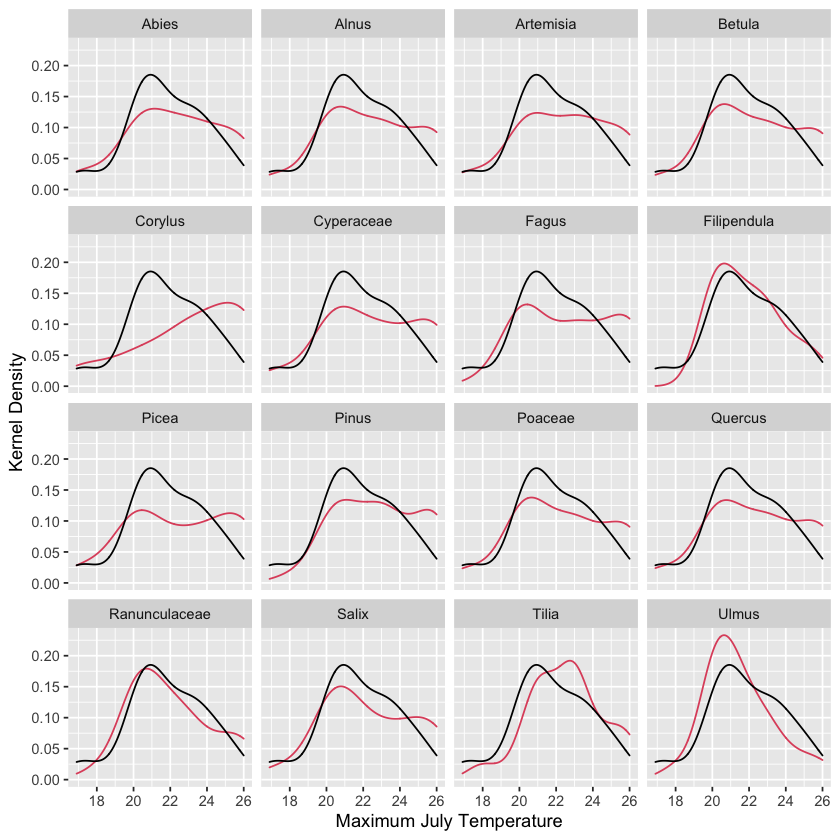

In [16]:
ggplot() +
  geom_density(data = pollen_subsamp,
               aes(x = round(tmax7 / 10, 0)), col = 2) +
  facet_wrap(~replacement) +
  geom_density(data = maxsamp, aes(x = tmax7 / 10)) +
  xlab("Maximum July Temperature") +
  ylab("Kernel Density")